In [2]:
import json
from Levenshtein import distance as word_difference
from gensim.utils import simple_preprocess
import re
import matplotlib.pyplot as plt
import pandas as pd
import math
from nltk.corpus import words
from tqdm import tqdm

Uncomment the following cell and run it once to download a list of all English words for use in fuzzy keyword matching.

In [3]:
# import nltk
# nltk.download('words')

This notebook requires a JSON file conatining an array of Open311 Service Request Objects. An example file, ```service_requests.json``` is provided in the data directory.

In [4]:
# Change this file name if using a different service request source.
SERVICE_REQ_JSON_FILE_NAME = 'data/service_requests.json'

In [5]:
def extract_request_id_with_description(filename:str) -> dict:
    ''' 
    For a given file containing a JSON Array of Service Request JSON Objects, extract the service number and the description
    (if it exists) into a dictionary for further preprocessing.

    Returns: Dict (Service Request ID -> Service Request Description)
    '''
    request_id_descr_dict = {}
    service_requests_json = json.loads(open(filename, 'r').read())

    for service_request in service_requests_json:
        # Ensure the description exists for this service request
        description = service_request.get('description', False)
        if not description: continue   

        # Deprecated code to append status notes (added by 311 to reports to detail the outcome / results) to the descriptions.
        # status_notes = service_request.get('status_notes', False)
        # if status_notes:
        #     description = description + ' | ' + status_notes

        # Add to dictionary using service request ID as key and service request description as value.
        request_id_descr_dict[service_request['service_request_id']] = description

    return request_id_descr_dict

In [6]:
# Load the 311 Service requests. Serves as the corpus for this notebook. 
# Corpus is composed of 311 Illegal Parking Service Request descriptions (documents).

document_dictionary = extract_request_id_with_description(SERVICE_REQ_JSON_FILE_NAME)

In [7]:
print(f'Total number of documents in the corpus: {len(document_dictionary.keys())}')

Total number of documents in the corpus: 19208


In order to identify infrastructure issues from the documents and classify them, the following classes and associated keywords have been defined.

The notebook can classify documents into one of an arbitrary number of classes with arbitrary keywords. Feel free to change the class structure and keywords. However, keywords should be specific enough to only apply to a single class.

In [8]:
class_keywords = {

    'Bike Infrastructure Issue': ['bike', 'cycle'],
    'Public Transit Infrastructure Issue': ['bus'],
    'Emergency Services Infrastructure Issue':  ['hydrant', 'fire'],
    'Resident Parking Violation': ['resident', 'nonresident', 'sticker'],
    'Driveway Obstrution': ['driveway'],
    'Pedestrian Infrastructure Issue':  ['crosswalk', 'sidewalk'],
    'ADA Infrastructure Issue': ['handicap'],
    'Traffic Flow Impediment': ['double', 'stopped']

}

In [9]:
def categorize_illegal_parking_reports(descriptions:dict, class_keywords:dict, max_distance:int=1):
    ''' 
    Given a corpus, classes and associated keywords, as well as a number of acceptable typos,
    classify as many documents in the courpus into a single class as possible.

    First match direct keywords, then look for typos up to the given limit.

    :param descriptions: dictionary corpus with document id as keys, document text as values
    :param class_keywords: dictionary mapping of class name (key) to list of keywords (value)
    :param max_distance: maximum number of typos allowed for a fuzzy keyword match. To disallow fuzzy matches, max_distance=0

    :returns: 
        uncategorized_descriptions: dictionary of document id to document text
        class_service_ids: dictionary of class names to list of document ids with keyword matches
        service_id_classes: dictionary of document ids to list of identified classes (currently only supports 1 class per document, but exists for extensibility)
        distance_matches: dictionary of typo-distances (int) to dictionary of fuzzy matches (class_service_ids format)
        keyword_matches: dictionary of document ids to a list of keyword matches in the document
    '''

    match_count = 0

    # Tokenize descriptions
    description_tokens = {id: simple_preprocess(description, deacc=True) for id, description in descriptions.items()}

    # Create new dictionary to keep track of descriptions that are not yet categorized
    uncategorized_descriptions = dict(description_tokens)

    # Create dictionary for the list of service ids for each class
    class_service_ids = {}

    # Create dictionary to track classes assigned to service ids (to analyze prevalance of multiclass descriptions)
    service_id_classes = {}

    # Create dictionary to track the keyword matches for categorized documents
    keyword_matches = {}

    # Find exact matches
    print('Finding exact matches...')
    uncategorized_descriptions_items = list(uncategorized_descriptions.items())
    for id, tokens in tqdm(uncategorized_descriptions_items):
        match_found = False
        for category, keywords in class_keywords.items():
            current_match = keywords_match(keywords, tokens)
            if current_match[0]:
                match_found = True
                match_count += 1

                # Track the match in all three dicts
                # keyword_class: [list of service ids]
                service_ids:list = class_service_ids.get(category, [])
                service_ids.append(id)
                class_service_ids[category] = service_ids

                # service_id: [list of keyword classes]
                classes = service_id_classes.get(id, [])
                classes.append(category)
                service_id_classes[id] = classes

                # service_id: [list of keyword matches]
                matched_keywords = keyword_matches.get(id, [])
                matched_keywords.append(current_match[1])
                keyword_matches[id] = matched_keywords
        
        # If any match was found remove it from the uncategorized dictionary
        if match_found: del uncategorized_descriptions[id]

    # find matches with increasing distance
    # create dictionary to hold fuzzy matches
    distance_matches = {}

    # Load list of valid English words
    valid_words = words.words()
    valid_words = list(map(lambda s: s.lower(), valid_words))

    print('Looking for typo matches...')
    for distance in range(max_distance): 
        distance += 1
        print(f'\t{distance} typo(es)')
        current_distance_matches = {}
        uncategorized_descriptions_items = list(uncategorized_descriptions.items())
        for id, tokens in tqdm(uncategorized_descriptions_items):
            match_found = False
            for category, keywords in class_keywords.items():
                current_match = keywords_fuzzy_match(keywords, tokens, distance, valid_words)
                if current_match[0]:
                    match_found = True
                    match_count += 1

                    # Track the match in all dicts
                    # keyword_class: [list of service ids]
                    service_ids = class_service_ids.get(category, [])
                    service_ids.append(id)
                    class_service_ids[category] = service_ids

                    # service_id: [list of keyword classes]
                    classes = service_id_classes.get(id, [])
                    classes.append(category)
                    service_id_classes[id] = classes

                    # distance(INTEGER) : dict of category matches for distance
                    distance_classes = current_distance_matches.get(category, [])
                    distance_classes.append(id)
                    current_distance_matches[category] = distance_classes

                    # service_id: [list of keyword matches]
                    matched_keywords = keyword_matches.get(id, [])
                    matched_keywords.append(current_match[1])
                    keyword_matches[id] = matched_keywords

            
            # If any match was found remove it from the uncategorized dictionary
            if match_found: del uncategorized_descriptions[id]
        
        distance_matches[distance] = current_distance_matches
    
    # print(f'Found {match_count} matches!')
    return uncategorized_descriptions, class_service_ids, service_id_classes, distance_matches, keyword_matches


def keywords_match(keywords:list[str], tokens:list[str]):
    ''' 
    Look for exact keyword matches in the tokens.
    '''
    affix_pattern = r'[a-z]*'
    for keyword in keywords:
        keyword_pattern = re.compile(affix_pattern + keyword + affix_pattern)
        all_tokens = str.join(' ', tokens)
        matches = re.findall(keyword_pattern, all_tokens)
        if matches:
            return True, str.join(', ', matches)
        
    return False, None

def keywords_fuzzy_match(keywords:list[str], tokens:list[str], distance:int, valid_words):
    ''' 
    Look for fuzzy keyword matches using Levenshtein edit distance.
    In order to reduce the amount of misidentifications, any typos must not exceed one-third of the length of the token.
    For example, the keyword 'bus' cannot be matched with 'mut' even if the number of allowable typoes is 4,
    because 2 edits is more than one-third of the token length.
    '''
    for keyword in keywords:
        for token in tokens:
            # if token in valid_words: continue
            difference = word_difference(keyword, token)
            if difference <= distance and difference >= math.ceil(len(token) * float(1/5)):
                # Try to catch correctly typed words here:
                if token in valid_words:
                    return False, None
                return True, f'({token}, {keyword})'
            
    return False, None

In [10]:
# Run the above functions:
unknown_desc, class_service_ids, service_id_classes, distance_matches, keyword_matches = categorize_illegal_parking_reports(document_dictionary, class_keywords, 0)

Finding exact matches...


100%|██████████| 19208/19208 [00:01<00:00, 9608.28it/s] 


Looking for typo matches...


In [11]:
print(f'# Unknown Documents: {len(unknown_desc)}')
print(f'# Classified Documents: {sum([len(class_service_ids[cat]) for cat in class_service_ids.keys()])}')
print(f'# Distance Matches: {sum([len(distance_matches[dist][cat]) for dist in distance_matches.keys() for cat in distance_matches[dist].keys()])}')

# Unknown Documents: 7382
# Classified Documents: 12976
# Distance Matches: 0


Take the results of the categorization and process them into DataFrames for visualization

In [12]:
class_distr = {cat: len(ids) for cat, ids in class_service_ids.items()}
class_distr_df = pd.DataFrame(data=class_distr, index=['num_ids'])
class_distr_df.head()

,Resident Parking Violation,Driveway Obstrution,Traffic Flow Impediment,Pedestrian Infrastructure Issue,ADA Infrastructure Issue,Emergency Services Infrastructure Issue,Bike Infrastructure Issue,Public Transit Infrastructure Issue
num_ids,4567,1359,813,1744,867,1808,841,977


([<matplotlib.patches.Wedge at 0x18ae0d06170>,
 [Text(0.4933529034154985, 0.983159657782752, 'Resident Parking Violation'),
  Text(-0.90715184372042, 0.6221539459286929, 'Driveway Obstrution'),
  Text(-1.096883295793229, 0.08274681510356578, 'Traffic Flow Impediment'),
  Text(-0.9413381584681824, -0.5691067311249546, 'Pedestrian Infrastructure Issue'),
  Text(-0.42316510143082614, -1.0153478699101304, 'ADA Infrastructure Issue'),
  Text(0.2750857696177946, -1.0650482709031481, 'Emergency Services Infrastructure Issue'),
  Text(0.8576136342033325, -0.6888387724486427, 'Bike Infrastructure Issue'),
  Text(1.0693702348461926, -0.2577737395954035, 'Public Transit Infrastructure Issue')])

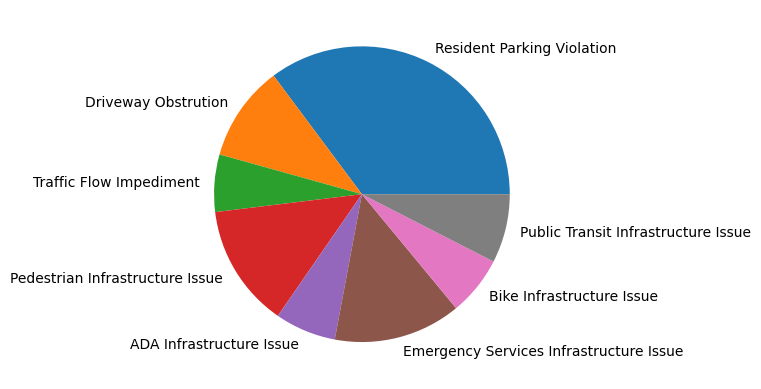

In [13]:
plt.clf()
plt.pie(x=class_distr.values(), labels=class_distr.keys())

## Packing up the classifications

Will be the same as the service request JSON objects, but will have an additional field 'CLASS' which is one of:
- resident parking
- blocked driveway
- blocked public transit infra
- traffic flow impediment
- blocked pedestrian infra
- blocked accesibility infra
- blocked emergency infra
- blocked bike infra
- unknown (uncategorized, contains no keywords within edit distance limit)

Additional field 'DIST' shows the edit distance of the service request. For example, a service request that contains a keyword with a single typo 
will have value 1. Two typos will have value 2.

In [14]:
CATEGORIZED_REPORTS_FILENAME = 'data/infra_issues.json'

In [15]:
# Load the json service requests into a dictionary with keys=id, values=json_obj
service_req_json = json.loads(open(SERVICE_REQ_JSON_FILE_NAME, 'r').read())

service_req_json_dict = {obj['service_request_id']: obj for obj in service_req_json}

# go through each class, find each service id json object, add the proper fields, then save the json

classified_service_requests = []

# Distance zero requests
distance = 0
for req_id, classes in service_id_classes.items():
    req_json = service_req_json_dict[req_id]
    req_json['class'] = classes
    req_json['distance'] = distance
    req_json['keyword_matches'] = keyword_matches[req_id]
    classified_service_requests.append(req_json)

# Distance requests
for dist, matches in distance_matches.items():
    distance = dist
    for class_name, ids in matches.items():
        for req_id in ids:
            req_json = service_req_json_dict[req_id]
            req_json['class'] = class_name
            req_json['distance'] = distance
            req_json['keyword_matches'] = keyword_matches[req_id]
            classified_service_requests.append(req_json)


with open(CATEGORIZED_REPORTS_FILENAME, 'w') as file:
    json.dump(classified_service_requests, file)
